In [78]:
import pandas as pd
import geopandas as gpd



In [79]:
points = gpd.read_file('./points.geojson')

flow = pd.read_csv('./sample_prescription_data.csv')

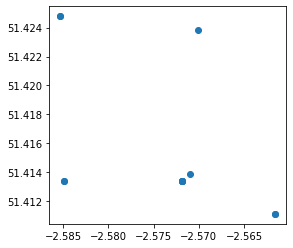

In [80]:
points.plot();

points = points.to_crs(wgs84)
points

In [81]:
import itertools
from geopy.distance import great_circle

In [82]:
# distance matrix
all_flows = pd.DataFrame( list( itertools.product(list(points['Place_ID'].unique()),list(points['Place_ID'].unique())))
                       ).rename(columns = {0:'Origin_ID',
                                        1:'Dest_ID'})
    
# create stripped column of coordinates 
points['xy'] = points.geometry.apply(lambda x: [x.y, x.x])
points = pd.DataFrame(points.loc[:,['Place_ID','xy']])


In [83]:
    
all_flows = all_flows.merge(points, how = 'left', left_on = 'Origin_ID', right_on = 'Place_ID').rename(columns = {'xy' : 'xy_O'})
all_flows = all_flows.merge(points, how = 'left', left_on = 'Dest_ID', right_on = 'Place_ID').rename(columns = {'xy' : 'xy_D'})
all_flows['distance'] = all_flows.apply(lambda x: great_circle(x.xy_O, x.xy_D).km, axis=1)
    


In [84]:
flow

,Unnamed: 0,Origin_ID,Dest_ID,Weight,distance,Dest_mass
0,0,L81031,FJQ15,22990.0,0.000000,34.850980
1,1,L81031,FPQ26,1043.0,1.164252,43.243548
2,2,L81031,FQ729,3297.0,0.759233,32.939583
3,3,L81031,FRA45,141.0,1.570402,44.295238
4,4,L81031,FRD73,2289.0,0.082952,36.152941
...,...,...,...,...,...,...
67,67,L81031,FPQ26,1965.0,1.164252,43.243548
68,68,L81031,FQ729,3894.0,0.759233,32.939583
69,69,L81031,FRA45,194.0,1.570402,44.295238
70,70,L81031,FRD73,3060.0,0.082952,36.152941


In [85]:
# Join the flows
flow = flow.loc[:,['Origin_ID','Dest_ID','Weight','Dest_mass']].groupby(['Origin_ID','Dest_ID']).mean().reset_index()
all_flows = all_flows.loc[:,['Origin_ID','Dest_ID', 'distance']].merge(flow.loc[:,['Origin_ID','Dest_ID','Weight']], how = 'left', on = ['Origin_ID','Dest_ID']
                                                              )
masses = flow.loc[:,['Dest_ID','Dest_mass']].groupby('Dest_ID').mean().reset_index()
all_flows = all_flows.merge(masses, how = 'left', on = 'Dest_ID')     

In [86]:
all_flows

,Origin_ID,Dest_ID,distance,Weight,Dest_mass
0,FHH76,FHH76,0.000000e+00,NaN,NaN
1,FHH76,FJQ15,7.592346e-01,NaN,34.850980
2,FHH76,FL370,2.241593e+00,NaN,NaN
3,FHH76,FPQ26,1.532345e+00,NaN,43.243548
4,FHH76,FQ729,0.000000e+00,NaN,32.939583
...,...,...,...,...,...
164,Y03791,DL81031,9.044392e-01,NaN,34.850980
165,Y03791,DY03791,9.343943e-07,NaN,NaN
166,Y03791,L81006,9.044384e-01,NaN,NaN
167,Y03791,L81031,9.044384e-01,NaN,NaN


In [87]:
import AFED
from timeit import default_timer as timer
import numpy as np

In [88]:
def AFED(flow_df, row_index): # AFAPF
    
    # rename teh columns so we can call them 
    flow_df = flow_df.rename(columns = {flow_df.columns[0]:'origin_ID', 
                                            flow_df.columns[1]:'dest_ID', 
                                            flow_df.columns[2]:'dist', 
                                            flow_df.columns[3]:'weight', 
                                            flow_df.columns[4]:'dest_mass'})
    # define O and D for each row the variables
    D = flow_df['dest_ID'][row_index]
    O = flow_df['origin_ID'][row_index]
    
    # get the list of possible destinations
    all_dest = (flow_df.query('origin_ID == @O')
                .query('weight > 0')
                ['dest_ID']
                .unique()
               )    
    
    # Create all destination flows 
    x1 = pd.DataFrame({'D': np.array([D]*len(all_dest), dtype=object), 
                       'dests':all_dest}).merge(flow_df, how='left', left_on=['D','dests'], right_on=['origin_ID','dest_ID'])
    
    # merge with the distances and masses 
    
    # Delete the flow to origin
    x1 = x1[~x1.dests.isin(list(O))]    

    # calculate the accessibility
    A = (x1['dist']*x1['dest_mass']).sum()

    return A

In [89]:
start = timer()

A_ij = []
for idx in all_flows.index:
    A = AFED(flow_df=all_flows, row_index=idx)
    A_ij.append(A)

end = timer()

all_flows['acc'] = pd.Series(A_ij)
print('time: ' + str(end - start))

time: 1.156890499999463


In [90]:
all_flows.describe()

,distance,Weight,Dest_mass,acc
count,169.000000,6.000000,78.000000,169.000000
mean,0.888485,5120.888889,37.722212,16.073708
std,0.661794,8267.256409,4.416146,58.233609
min,0.000000,136.833333,32.939583,0.000000
25%,0.082952,638.250000,34.850980,0.000000
50%,0.904438,2541.708333,35.501961,0.000000
75%,1.550676,3455.354167,43.243548,0.000000
max,2.241593,21741.416667,44.295238,285.937885


In [95]:
all_flows_ch = all_flows.loc[:,['Origin_ID','Dest_ID','distance','Weight','Dest_mass']]
all_flows_ch.loc[144,['Weight']] = 0

In [96]:
all_flows_ch.sort_values(by='Weight', ascending=False)

,Origin_ID,Dest_ID,distance,Weight,Dest_mass
147,L81031,FQ729,7.592355e-01,3541.500000,32.939583
149,L81031,FRD73,8.295220e-02,3196.916667,36.152941
146,L81031,FPQ26,1.164264e+00,1886.500000,43.243548
148,L81031,FRA45,1.570464e+00,222.166667,44.295238
151,L81031,DL81031,9.348206e-07,136.833333,34.850980
...,...,...,...,...,...
164,Y03791,DL81031,9.044392e-01,NaN,34.850980
165,Y03791,DY03791,9.343943e-07,NaN,NaN
166,Y03791,L81006,9.044384e-01,NaN,NaN
167,Y03791,L81031,9.044384e-01,NaN,NaN


In [97]:
start = timer()

A_ij = []
for idx in all_flows_ch.index:
    A = AFED(flow_df=all_flows_ch, row_index=idx)
    A_ij.append(A)

end = timer()

all_flows['acc_ch'] = pd.Series(A_ij)
print('time: ' + str(end - start))

time: 1.1421278999996503


In [100]:
all_flows['diff'] = all_flows['acc'] - all_flows['acc_ch']
all_flows['diff'].describe()

count    169.000000
mean       1.591080
std        7.945319
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       54.732235
Name: diff, dtype: float64